The purpose of this notebook is simple, calculate the number of guides that have a SNV in them in at least one cell line. I've already written most of this code in other notebooks, it is just a matter of pulling it all togethere here and counting it.

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 
head(avana.bed)

,chr,start,end,sgrna
,<chr>,<int>,<dbl>,<chr>
1,chr1,69527,69550,TCTCCATTCGGTGAGCCAGT
2,chr1,168646,168669,TGTAGTCCCAGCTACTCAGG
3,chr1,383420,383443,GAGAATCTCTTGAACCCGGG
4,chr1,424270,424293,TGTAATCCCAGTACTTTGGG
5,chr1,451271,451294,ATAATGGTCAGATAGTGGAG
6,chr1,451344,451367,TCTCCACACCACCAACGACG


In [3]:
#Filter the ccle variant calls so that it only includes SNPs that map to at least one sgRNA targeting sequence
#Now use bcftools to subset the big ccle snp matrix to only include SNPs in that range
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
/home/jupyter/Ancestry/software/bcftools/bcftools view -R /home/jupyter/Ancestry/filtered_output/avana14/Avana14_filtering.bed split.all_chroms.maf.subset.reheader.vcf.gz -o /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.all.avana.guides.vcf.gz -Oz
"))

In [3]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
ccle.variant.calls = ccle.variant.calls %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

head(ccle.variant.calls)
dim(ccle.variant.calls)


#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)
head(sample.names)


ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("chr", "pos", "ref", "alt", sample.names)
head(ccle.variant.calls)

,chr,pos,ref,alt,V10,V11,V12,V13,V14,V15,⋯,V994,V995,V996,V997,V998,V999,V1000,V1001,V1002,V1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


[1] 3432  998

[1] "ACH-000657" "ACH-000617" "ACH-000685" "ACH-000632" "ACH-000171"
[6] "ACH-000863"

,chr,pos,ref,alt,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


In [4]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
  
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = ccle.variant.calls %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [5]:
#Assign the SNP ID as names for each vector

annotated.snp.in.guide.list = NULL
for(i in 1:length(snp.in.guide.list)){
        
    chromosome = avana.bed$chr[i] #get the chromosome which that guide targets
    
    #Now get a vector of snp positions and annotate the relative snp position vector with that information
    vector.to.annotate = snp.in.guide.list[[i]] #grab the vector that we need to annotate in this loop
    snp.vector = ccle.variant.calls %>% filter(chr %in% chromosome) %>% mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep = "")) %>% pull(snp) #make a vector that contains the snp information
    names(vector.to.annotate) = snp.vector #now apply that annotation to the vector of snp positions
    
    #Report the information outside of the loop
    annotated.snp.in.guide.list[[i]] = vector.to.annotate
    
}

names(annotated.snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [6]:
#Go through the list and remove the SNPs that don't map to a sgrna
pruned.snp.list = annotated.snp.in.guide.list %>%
lapply(function(x){
    vector = abs(x)
    val.to.return = vector[vector %in% 0:22]
    return(val.to.return)
}) %>% compact(1) #compact is part of the purrr package and will remove guides that don't have a SNP

head(pruned.snp.list)
length(pruned.snp.list)

$GGGATGACTGCCACGTCGCA
chr1:1918305:G:A 
              15 

$CACCAGCTACCGCTTCACCA
chr1:2028260:G:A 
              12 

$TGAACTCATCACAATCACAG
chr1:2351722:A:G 
               8 

$GCAGTGTCACCAGCACGCCA
chr1:2408761:T:C chr1:2408773:G:A 
               5               17 

$GCTCAGGGACCACAGTCCCG
chr1:2645520:C:T 
              18 

$CGTACGTTCCTTCTAGAGCA
chr1:3844915:C:T 
               5

[1] 3870

In [7]:
#Now let's go through and create a nice data frame from this list.

snp.in.guide.df = NULL
for(i in 1:length(pruned.snp.list)){
    
   sgrna = pruned.snp.list[[i]] #this is a vector (normally length = 1, sometimes more with all of the snps that map to a vector)
   
    #If there is only one snp that maps to that sgrna, simply construct the vector and add it to the data frame
    #If there is more than one snp, then we need to get a little more fancy and construct a data frame first
    if(length(sgrna) == 1){
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        snp = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        vector.to.add = c(sgrna, snp, position) #Make a vector of values to add to the data frame
        snp.in.guide.df = rbind(snp.in.guide.df, vector.to.add) %>% data.frame() %>% #Then add that vector to the data frame
        rename("sgrna" = 1, "snp" = 2, "position" = 3)  
    } else {
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        sgrna.vector = rep(sgrna, length(pruned.snp.list[[i]])) #get a vector that contains the sgrna now, length = #snps
        snp.vector = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position.vector = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        df.to.add = cbind(sgrna.vector, snp.vector, position.vector) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3) #bind it all into a data frame
        snp.in.guide.df = rbind(snp.in.guide.df, df.to.add) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3)
 }
}

row.names(snp.in.guide.df) = NULL #remove the row names on the new df since they are useless
head(snp.in.guide.df)
dim(snp.in.guide.df)

,sgrna,snp,position
,<chr>,<chr>,<chr>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,8
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18


[1] 4104    3

In [8]:
#Format ccle.variant.calls so that it is ready for our analysis
ccle.calls.for.analysis = ccle.variant.calls %>%
mutate("snp" = paste(chr, ":", pos, ":", ref, ":", alt, sep = ""), .before = chr) %>%
select(-chr, -pos, -ref, -alt)

head(ccle.calls.for.analysis)

,snp,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1:1407014:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1:1471992:T:C,2,2,1,0,1,0,0,0,1,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1:1918305:G:A,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1:2028260:G:A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1:2351722:A:G,2,0,1,1,0,0,0,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1:2408761:T:C,1,2,2,2,2,2,1,2,1,⋯,2,2,2,2,1,1,0,2,1,2


In [9]:
#Next step is calculate the population frequency for all guides

all.unique.guides = snp.in.guide.df %>%
pull(sgrna) %>%
unique()

guide.frequency = NULL
for(guide in all.unique.guides){
    
    #First get all of the SNPs we are interested in
    snps.to.grab = snp.in.guide.df %>% 
    filter(sgrna %in% guide) %>%
    pull(snp)
    
    #Pull those SNPs out of the ccle variant calls dataframe
    #And collapse by maximum if necessary
    if(length(snps.to.grab) > 1){
    collapsed.snp.calls = ccle.calls.for.analysis %>%
    filter(snp %in% snps.to.grab) %>%
    select(-snp) %>%
    apply(2, max) %>%
    as.numeric() 
    
    } else { 
        
    collapsed.snp.calls = ccle.calls.for.analysis %>%
    filter(snp %in% snps.to.grab) %>%
    select(-snp)
    }
    
    #Get calculate how many cell lines have a SNP in that sgRNA
    cells.with.snp = collapsed.snp.calls[collapsed.snp.calls >= 1] %>% length()
    
    #return that information outside of the loop
    guide.frequency = c(guide.frequency, cells.with.snp)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



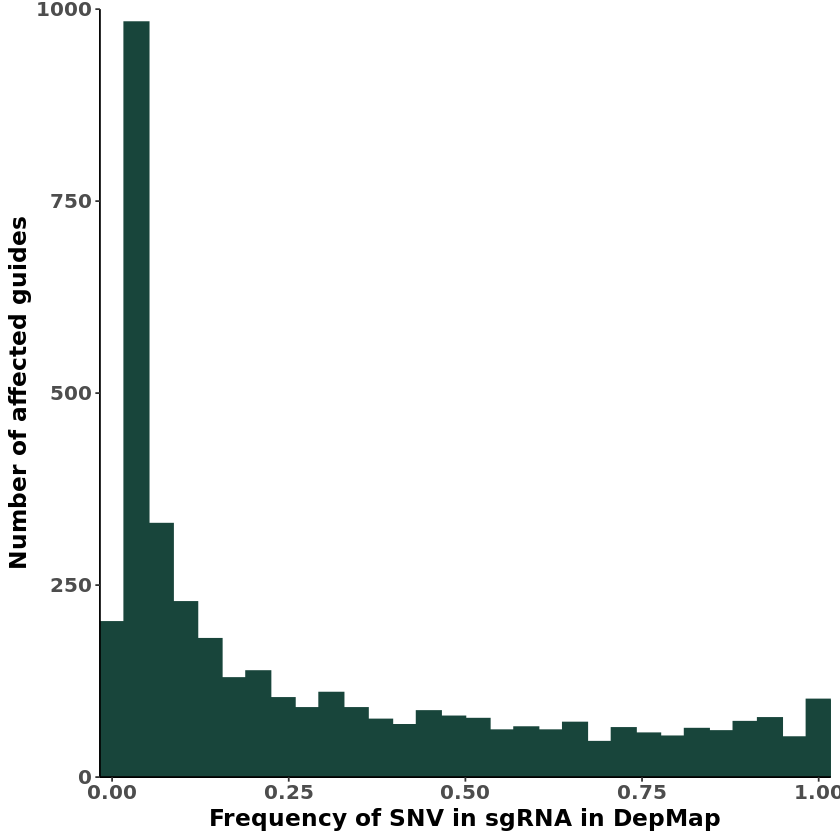

In [10]:
#Now make a plot of the frequency distribution
normalized.guide.frequency = guide.frequency/(ncol(ccle.calls.for.analysis)-1)

#Make the dataframe for plotting
df.for.plotting = cbind(all.unique.guides, normalized.guide.frequency) %>%
data.frame() %>%
rename("sgrna" = 1, "frequency" = 2) %>%
mutate(frequency = as.numeric(frequency))

#plot the plot
df.for.plotting %>%
ggplot(aes(x = frequency)) +
geom_histogram(color = rgb(24, 69, 59, maxColorValue = 255), fill = rgb(24, 69, 59, maxColorValue = 255)) +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), limits = c(0, 1000)) +


ylab("Number of affected guides") +
xlab("Frequency of SNV in sgRNA in DepMap")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("depmap_frequency_affected.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp depmap_frequency_affected.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [12]:
#Export the dataframe so that we don't need to always re-make it
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
write.table(df.for.plotting, "frequency_of_affected_avana_guides.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

head(df.for.plotting)

,sgrna,frequency
,<chr>,<dbl>
1,GGGATGACTGCCACGTCGCA,0.16096579
2,CACCAGCTACCGCTTCACCA,0.01509054
3,TGAACTCATCACAATCACAG,0.27665996
4,GCAGTGTCACCAGCACGCCA,0.90744467
5,GCTCAGGGACCACAGTCCCG,0.01810865
6,CGTACGTTCCTTCTAGAGCA,0.58048290


In [4]:
#re-load the data frame
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
df.for.plotting = read.table("frequency_of_affected_avana_guides.txt", sep = "\t", header = T)

In [5]:
#Calculate the fraction of guides that fall above a certain cutoff

total.number = normalized.guide.frequency %>% length()
fraction.above.25 = normalized.guide.frequency[normalized.guide.frequency > 0.25] %>% length()
fraction.above.50 = normalized.guide.frequency[normalized.guide.frequency > 0.50] %>% length()
fraction.above.75 = normalized.guide.frequency[normalized.guide.frequency > 0.75] %>% length()


total.number
fraction.above.25
fraction.above.50
fraction.above.75

percent.above.25 = (fraction.above.25/total.number)*100
percent.above.50 = (fraction.above.50/total.number)*100
percent.above.75 = (fraction.above.75/total.number)*100

percent.above.25
percent.above.50
percent.above.75

#calculate the fraction of guides affected at this cutoff across all of depmap
guides.in.depmap = avana.bed %>% pull(sgrna) %>% unique() %>% length()

depmap.percent.above.25 = (fraction.above.25/guides.in.depmap)*100
depmap.percent.above.50 = (fraction.above.50/guides.in.depmap)*100
depmap.percent.above.75 = (fraction.above.75/guides.in.depmap)*100

depmap.percent.above.25
depmap.percent.above.50
depmap.percent.above.75

total.guides.with.a.snp = (total.number/guides.in.depmap)*100
total.guides.with.a.snp


ERROR: Error in normalized.guide.frequency %>% length(): object 'normalized.guide.frequency' not found


# Create a new version of the figure for the paper that includes all of the data

In [6]:
###Add in all of the guides that are not affected.
affected.guides = df.for.plotting %>% pull(sgrna) %>% unique()
unaffected.guides = setdiff(avana.bed$sgrna, affected.guides)

#construct the dataframe with both the affected and the unaffected guides
total.affected.df = unaffected.guides %>%
data.frame() %>%
mutate("frequency" = 0) %>%
rename("sgrna" = 1) %>%
rbind(df.for.plotting)

head(total.affected.df)

,sgrna,frequency
,<chr>,<dbl>
1,TCTCCATTCGGTGAGCCAGT,0
2,TGTAGTCCCAGCTACTCAGG,0
3,GAGAATCTCTTGAACCCGGG,0
4,TGTAATCCCAGTACTTTGGG,0
5,ATAATGGTCAGATAGTGGAG,0
6,TCTCCACACCACCAACGACG,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



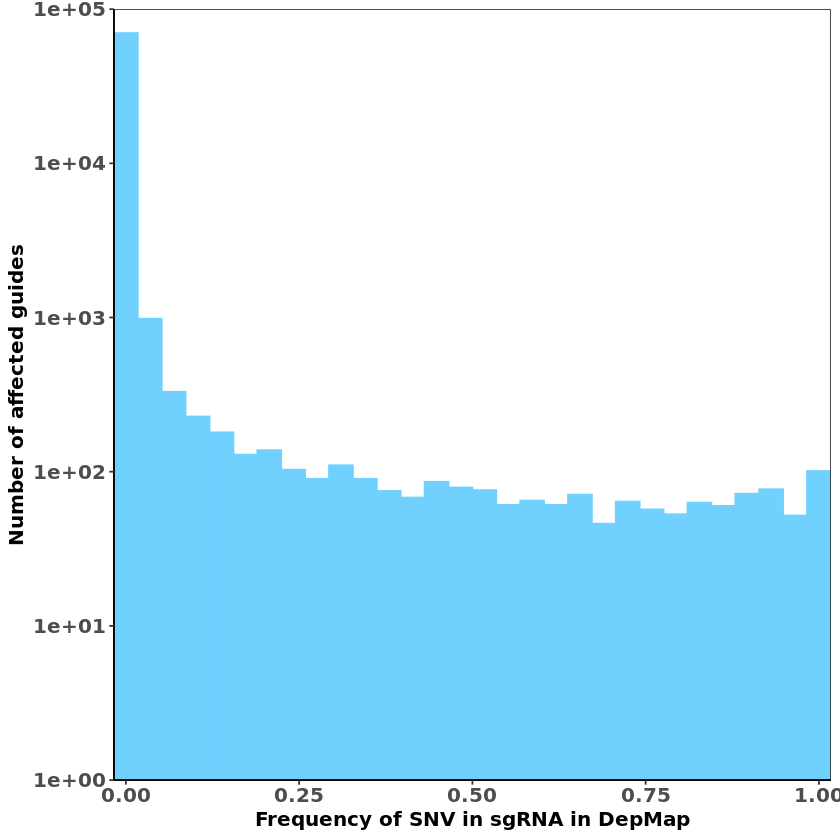

In [48]:
#Plot the plot!

total.affected.df %>%
ggplot(aes(x = frequency)) +
geom_histogram(color = "#70d1ff", fill = "#70d1ff") +
theme_bw() +


theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), trans = "log10", breaks = c(1, 10, 100, 1000, 10000, 100000), limits=c(1, 100000)) +

ylab("Number of affected guides") +
xlab("Frequency of SNV in sgRNA in DepMap")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("depmap_frequency_affected.pdf", width = 3.3, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp depmap_frequency_affected.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [11]:
#Calculate the total number of guides that are affected in > 10 cell lines
freq.for.cutoff = (994*0.01)/100

df.for.plotting %>%
filter(frequency > freq.for.cutoff) %>%
nrow()

[1] 2262